In [1]:
%pip install pandas
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install lightgbm
%pip install xgboost
%pip install catboost
%pip install joblib
%pip install scikit-learn

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
DATA_PATH = '..'

In [4]:
df_train = pd.read_csv(f'{DATA_PATH}/optiver-trading-at-the-close/train.csv')
df_test = pd.read_csv(f'{DATA_PATH}/optiver-trading-at-the-close/example_test_files/test.csv')
revealed_targets = pd.read_csv(f'{DATA_PATH}/optiver-trading-at-the-close/example_test_files/revealed_targets.csv')
sample_submission = pd.read_csv(f'{DATA_PATH}/optiver-trading-at-the-close/example_test_files/sample_submission.csv')

In [5]:
df_train.columns

Index(['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap', 'target', 'time_id', 'row_id'],
      dtype='object')

In [6]:
indices = ['stock_id', 'date_id','time_id', 'row_id','target']

features = ['seconds_in_bucket', 'imbalance_buy_sell_flag',
            'imbalance_size', 'matched_size', 'bid_size', 'ask_size',
            'reference_price','far_price', 'near_price', 'ask_price', 'bid_price', 'wap',
            'imb_s1', 'imb_s2']

In [7]:
def enrich_features(df):

    df_ = df.copy()

    df_['imb_s1'] = df.eval('(bid_size-ask_size)/(bid_size+ask_size)')
    df_['imb_s2'] = df.eval('(imbalance_size-matched_size)/(matched_size+imbalance_size)')
    
    prices = ['reference_price','far_price', 'near_price', 'ask_price', 'bid_price', 'wap']
    
    for i,a in enumerate(prices):
        for j,b in enumerate(prices):
            if i>j:
                df_[f'{a}_{b}_imb'] = df_.eval(f'({a}-{b})/({a}+{b})')
                features.append(f'{a}_{b}_imb')    
                    
    for i,a in enumerate(prices):
        for j,b in enumerate(prices):
            for k,c in enumerate(prices):
                if i>j and j>k:
                    max_ = df_[[a,b,c]].max(axis=1)
                    min_ = df_[[a,b,c]].min(axis=1)
                    mid_ = df_[[a,b,c]].sum(axis=1)-min_-max_

                    df_[f'{a}_{b}_{c}_imb2'] = (max_-mid_)/(mid_-min_ + 0.1)
                    features.append(f'{a}_{b}_{c}_imb2')
    
    return df_

# TRAINING = True
# if TRAINING:
#     df_train = pd.read_csv(f'{DATA_PATH}/train.csv')
#     df_ = generate_features(df_train)
df_train_ = enrich_features(df_train)

In [20]:
df_train_.columns

Index(['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap', 'target', 'time_id', 'row_id', 'imb_s1', 'imb_s2',
       'far_price_reference_price_imb', 'near_price_reference_price_imb',
       'near_price_far_price_imb', 'ask_price_reference_price_imb',
       'ask_price_far_price_imb', 'ask_price_near_price_imb',
       'bid_price_reference_price_imb', 'bid_price_far_price_imb',
       'bid_price_near_price_imb', 'bid_price_ask_price_imb',
       'wap_reference_price_imb', 'wap_far_price_imb', 'wap_near_price_imb',
       'wap_ask_price_imb', 'wap_bid_price_imb',
       'near_price_far_price_reference_price_imb2',
       'ask_price_far_price_reference_price_imb2',
       'ask_price_near_price_reference_price_imb2',
       'ask_price_near_price_far_price_imb2',
       'bid_price_far_price_reference_price_imb2',
  

<Axes: >

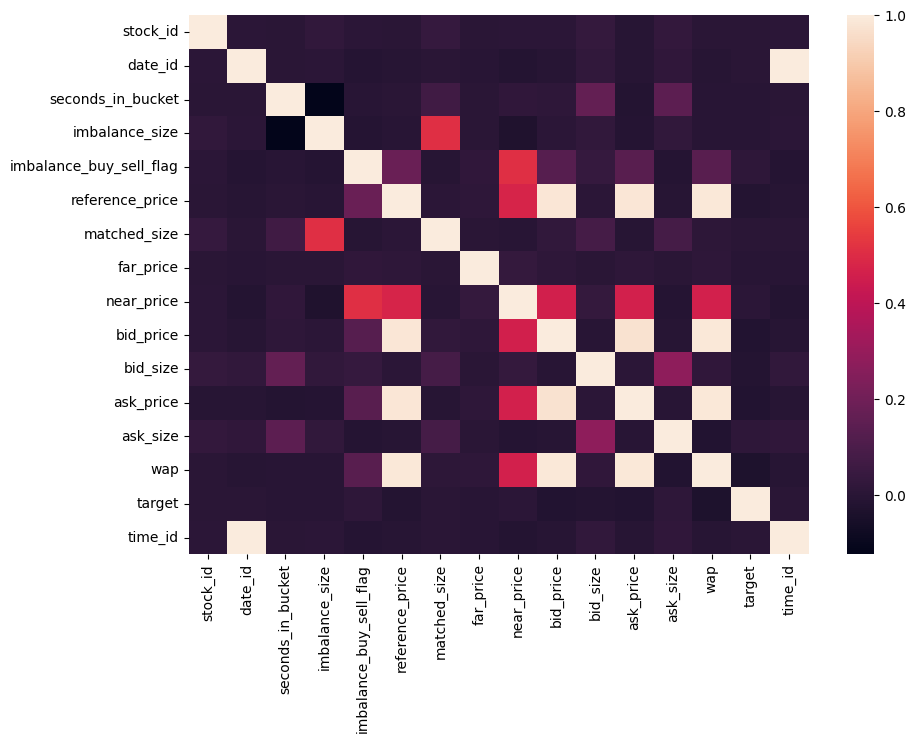

In [ ]:
plt.figure(figsize=(10, 7))
sns.heatmap(df_train.iloc[:, :-1].corr())


In [ ]:
df_train.iloc[:, :-1].corr().target.sort_values()

wap                       -0.035165
bid_price                 -0.022326
ask_price                 -0.021674
bid_size                  -0.018000
reference_price           -0.017394
seconds_in_bucket         -0.002203
far_price                 -0.001804
imbalance_size            -0.001190
stock_id                   0.000130
matched_size               0.000197
time_id                    0.000889
date_id                    0.000893
near_price                 0.006045
ask_size                   0.014936
imbalance_buy_sell_flag    0.015102
target                     1.000000
Name: target, dtype: float64

<Axes: >

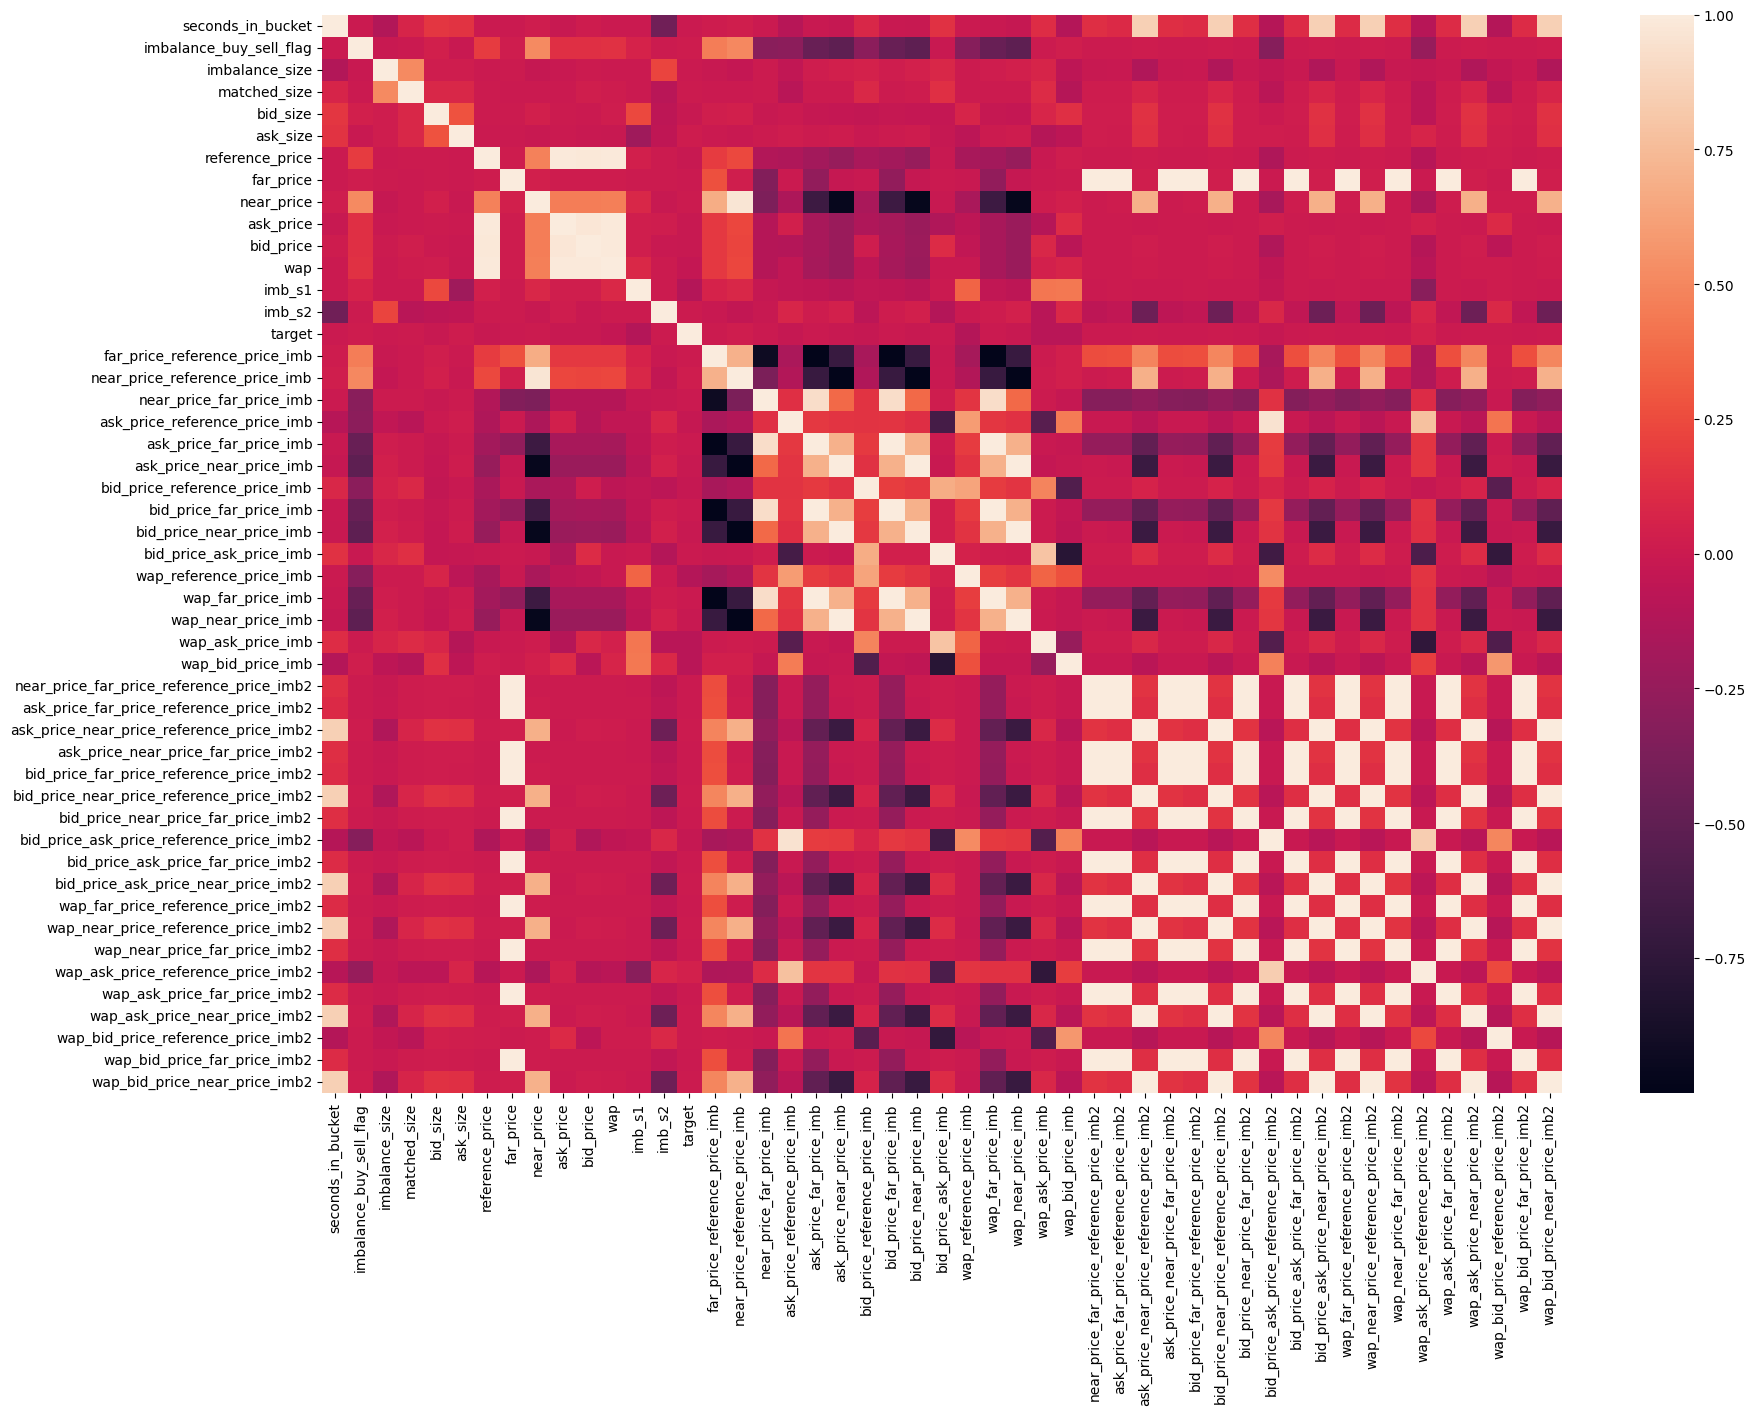

In [ ]:
plt.figure(figsize=(20,14))
# sns.heatmap(df_train_[features].iloc[:, :-1].corr())
sns.heatmap(df_train_[features].iloc[:, :-1].corr(), cmap="Spectral")

<Axes: title={'center': 'Stock 0 on Day 0 - How the order book pricing changes during the auction'}, xlabel='seconds_in_bucket'>

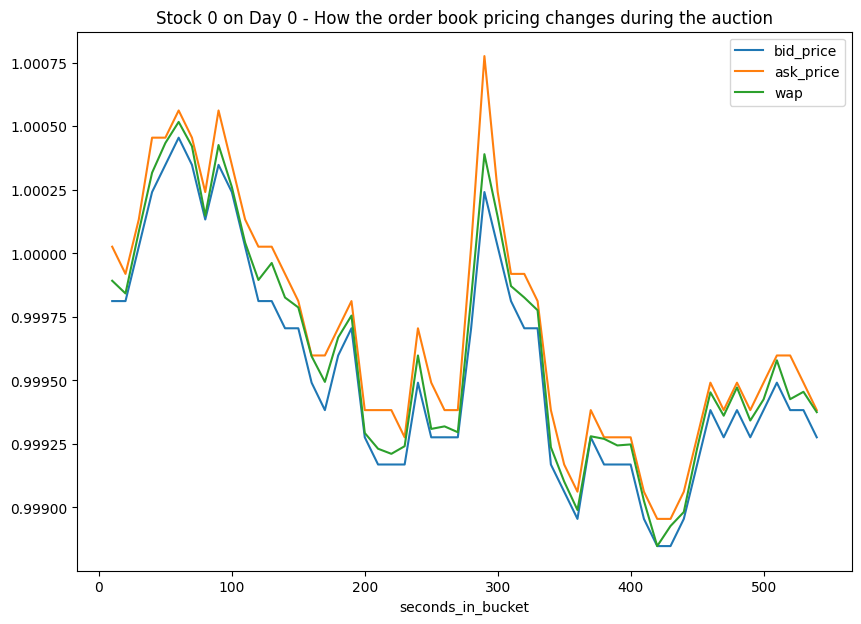

In [ ]:
# (
#     df_train
#     .query('stock_id ==0 & date_id ==0')
#     [['seconds_in_bucket','bid_price','ask_price', 'wap']]
#     .replace(0, np.nan)
#     .set_index('seconds_in_bucket')
#     .plot(title='Stock 0 on Day 0 - How the order book pricing changes during the auction',
#          figsize=(10, 7))
# )
(
    df_train
    .query('stock_id ==0 & date_id ==0')
    [['seconds_in_bucket','bid_price','ask_price', 'wap', 'near_price', 'far_price']]
    .replace(0, np.nan)
    .set_index('seconds_in_bucket')
    .plot(title='Stock 0 on Day 0 - How the order book pricing changes during the auction',
         figsize=(10, 7))
)

In [ ]:
df_train_.iloc[:, :-1].corr().target.sort_values()

imb_s1                                      -0.114617
wap_reference_price_imb                     -0.112435
wap_ask_price_imb                           -0.089753
wap_bid_price_imb                           -0.087378
wap                                         -0.035165
bid_price_reference_price_imb               -0.025835
bid_price_ask_price_reference_price_imb2    -0.024434
ask_price_reference_price_imb               -0.023632
bid_price                                   -0.022326
wap_near_price_imb                          -0.021925
ask_price                                   -0.021674
ask_price_near_price_imb                    -0.019841
bid_price_near_price_imb                    -0.019584
bid_size                                    -0.018000
reference_price                             -0.017394
wap_far_price_imb                           -0.007350
ask_price_far_price_imb                     -0.006279
bid_price_far_price_imb                     -0.006180
bid_price_ask_price_imb     

<Axes: xlabel='ask_size'>

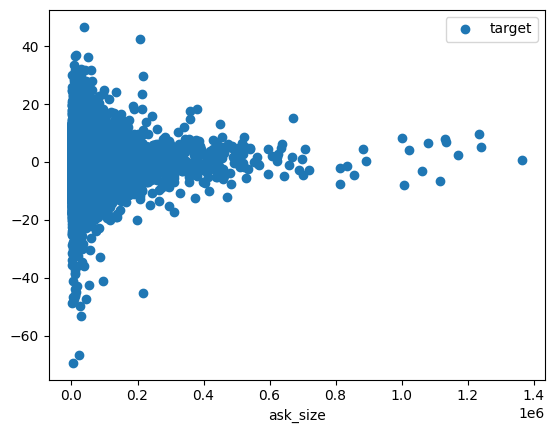

In [ ]:
first_stock = df_train_[(df_train_["stock_id"]==0)]
first_stock.plot(x='ask_size', y='target', style='o')

<Axes: xlabel='ask_size'>

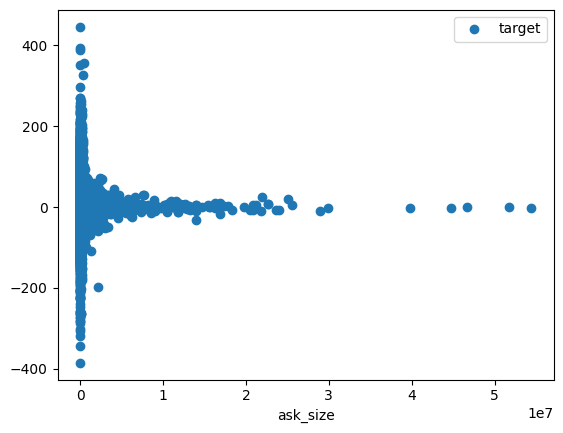

In [46]:
df_train_[~((df_train_["stock_id"]==0) & (df_train_["date_id"] ==0))].plot(x='ask_size', y='target', style='o')

<Axes: xlabel='imbalance_buy_sell_flag'>

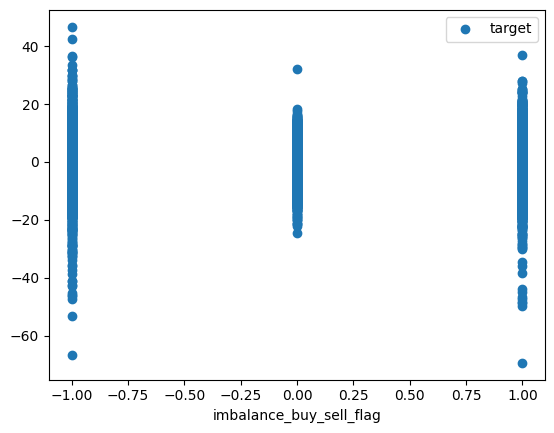

In [ ]:
first_stock.plot(x='imbalance_buy_sell_flag', y='target', style='o')

In [47]:
df_train_[~((df_train_["stock_id"]==0) & (df_train_["date_id"] ==0))]

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,...,wap_far_price_reference_price_imb2,wap_near_price_reference_price_imb2,wap_near_price_far_price_imb2,wap_ask_price_reference_price_imb2,wap_ask_price_far_price_imb2,wap_ask_price_near_price_imb2,wap_bid_price_reference_price_imb2,wap_bid_price_far_price_imb2,wap_bid_price_near_price_imb2,wap_bid_price_ask_price_imb2
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,...,-1.111240e+00,-1.111240e+00,-1.052632e+00,6.593143e-03,-1.111844e+00,-1.111844e+00,0.001040,-1.111240,-1.111240,0.006593
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,...,-1.111653e+00,-1.111653e+00,-1.052632e+00,2.966975e-03,-1.111442e+00,-1.111442e+00,0.004383,-1.111849,-1.111849,0.002962
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,...,-1.111301e+00,-1.111301e+00,-1.052632e+00,4.292660e-04,-1.111349e+00,-1.111349e+00,0.001710,-1.111112,-1.111112,0.002140
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,...,-1.111689e+00,-1.111689e+00,-1.052632e+00,1.592547e-04,-1.111129e+00,-1.111129e+00,0.004674,-1.111860,-1.111860,0.000159
5,5,0,0,0.00,0,1.000635,13552875.92,NaN,NaN,0.999779,...,-1.111817e+00,-1.111817e+00,-1.052632e+00,0.000000e+00,-1.111817e+00,-1.111817e+00,0.006336,-1.111384,-1.111384,0.006336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,...,1.093624e-04,1.093624e-04,5.940000e-03,1.059883e-03,1.053741e-03,1.053741e-03,0.000110,0.000109,0.000109,0.001060
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,...,1.751000e-03,1.755488e-03,4.318900e-03,8.085769e-04,8.044493e-04,8.065078e-04,0.001760,0.001751,0.001755,0.000809
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,...,8.000000e-05,8.000000e-05,8.000000e-05,8.599312e-04,8.599312e-04,8.599312e-04,0.000080,0.000080,0.000080,0.000860
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,...,-2.215970e-15,-2.215970e-15,-2.215970e-15,-2.215970e-15,-2.215970e-15,-2.215970e-15,0.002019,0.002019,0.002019,0.002019


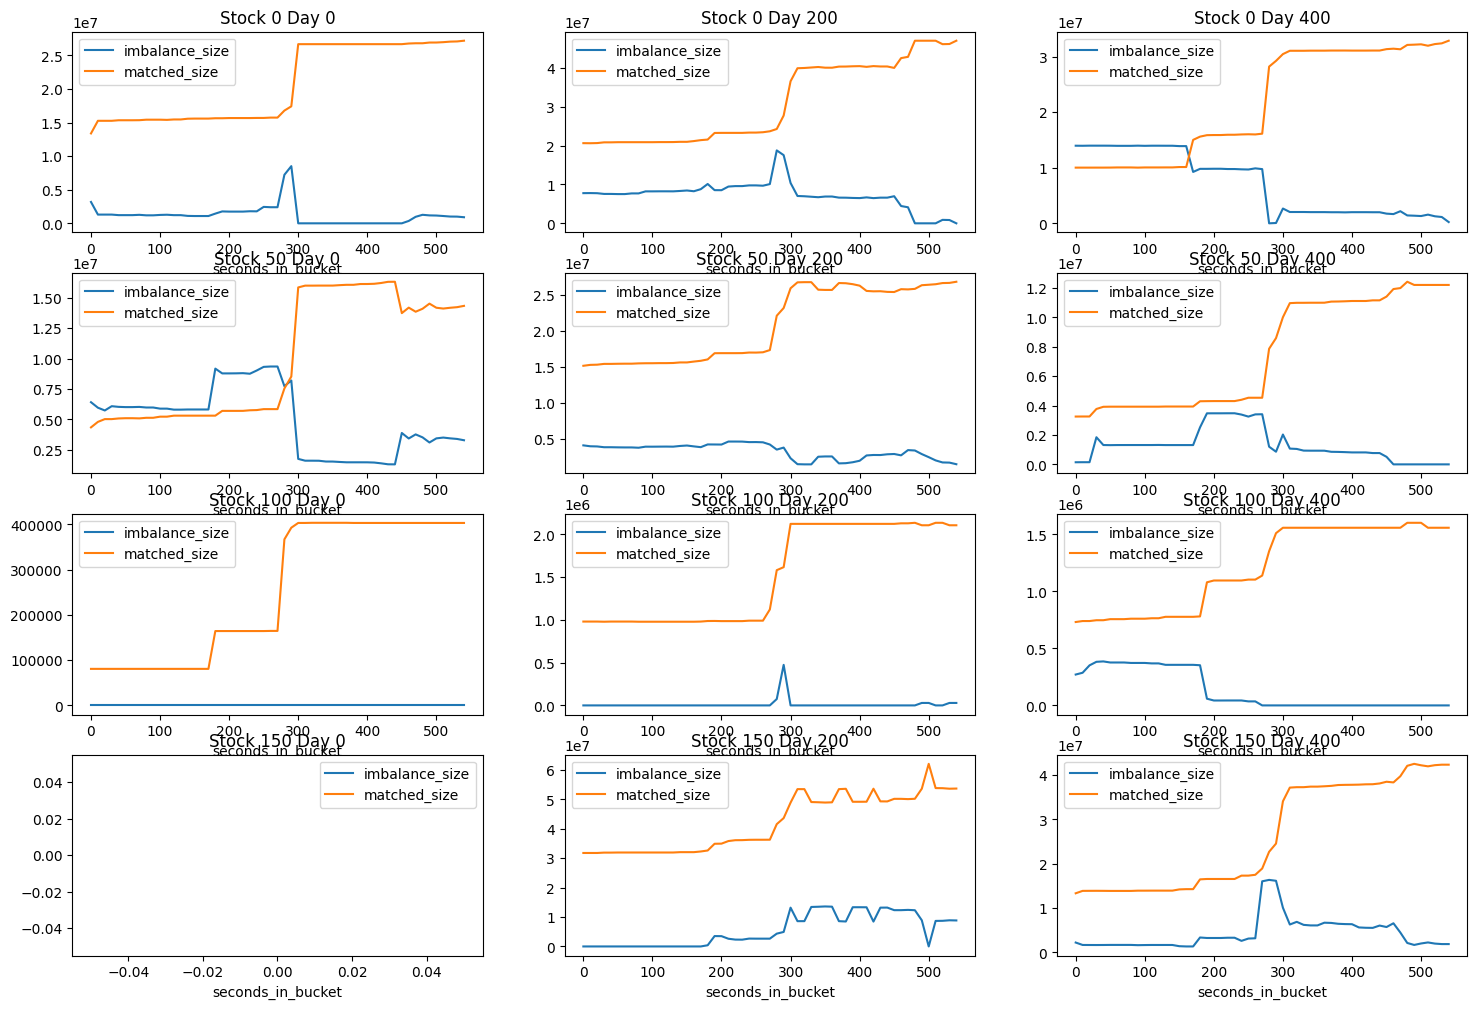

In [ ]:
# plt.figure(figsize=(20,14))
fig, axes = plt.subplots(4, 3, figsize=(18, 12))
# fig.canvas.set_window_title('How the auction sizing changes during the auction period')

for stock in [0, 50, 100, 150]:
    for day in [0, 200, 400]:
        axes[int(stock/50),int(day/200)].title.set_size(1)
        (            
            df_train
            .query(f"stock_id =={stock} & date_id =={day}")
            [['seconds_in_bucket','imbalance_size','matched_size']]
            .set_index('seconds_in_bucket')
            .plot(title=f"Stock {stock} Day {day}", ax=axes[int(stock/50),int(day/200)])
        )

In [8]:
import lightgbm as lgb 
import xgboost as xgb 
import catboost as cbt 
import numpy as np 
import joblib 
import os
import sklearn 

In [9]:
sklearn.__version__

'1.3.2'

In [10]:
os.system('mkdir models')

1

In [11]:
df_train_.isna().sum()

stock_id                                           0
date_id                                            0
seconds_in_bucket                                  0
imbalance_size                                   220
imbalance_buy_sell_flag                            0
reference_price                                  220
matched_size                                     220
far_price                                    2894342
near_price                                   2857180
bid_price                                        220
bid_size                                           0
ask_price                                        220
ask_size                                           0
wap                                              220
target                                            88
time_id                                            0
row_id                                             0
imb_s1                                            87
imb_s2                                        

In [12]:
df_train_[features].columns

Index(['seconds_in_bucket', 'imbalance_buy_sell_flag', 'imbalance_size',
       'matched_size', 'bid_size', 'ask_size', 'reference_price', 'far_price',
       'near_price', 'ask_price', 'bid_price', 'wap', 'imb_s1', 'imb_s2',
       'far_price_reference_price_imb', 'near_price_reference_price_imb',
       'near_price_far_price_imb', 'ask_price_reference_price_imb',
       'ask_price_far_price_imb', 'ask_price_near_price_imb',
       'bid_price_reference_price_imb', 'bid_price_far_price_imb',
       'bid_price_near_price_imb', 'bid_price_ask_price_imb',
       'wap_reference_price_imb', 'wap_far_price_imb', 'wap_near_price_imb',
       'wap_ask_price_imb', 'wap_bid_price_imb',
       'near_price_far_price_reference_price_imb2',
       'ask_price_far_price_reference_price_imb2',
       'ask_price_near_price_reference_price_imb2',
       'ask_price_near_price_far_price_imb2',
       'bid_price_far_price_reference_price_imb2',
       'bid_price_near_price_reference_price_imb2',
       'bid

In [13]:
df_train_.columns

Index(['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap', 'target', 'time_id', 'row_id', 'imb_s1', 'imb_s2',
       'far_price_reference_price_imb', 'near_price_reference_price_imb',
       'near_price_far_price_imb', 'ask_price_reference_price_imb',
       'ask_price_far_price_imb', 'ask_price_near_price_imb',
       'bid_price_reference_price_imb', 'bid_price_far_price_imb',
       'bid_price_near_price_imb', 'bid_price_ask_price_imb',
       'wap_reference_price_imb', 'wap_far_price_imb', 'wap_near_price_imb',
       'wap_ask_price_imb', 'wap_bid_price_imb',
       'near_price_far_price_reference_price_imb2',
       'ask_price_far_price_reference_price_imb2',
       'ask_price_near_price_reference_price_imb2',
       'ask_price_near_price_far_price_imb2',
       'bid_price_far_price_reference_price_imb2',
  

In [15]:
df_train_.shape[0]

5237980

In [16]:
X = df_train_.dropna(subset=['target'])[features].values
X.shape

(5237892, 49)

In [17]:
Y = df_train_.dropna(subset=['target'])['target'].values
Y.shape

(5237892,)

In [18]:
N_fold = 5

In [19]:
model_dict = {
    'lgb': lgb.LGBMRegressor(objective='regression_l1', n_estimators=50),
    'xgb': xgb.XGBRegressor(tree_method='hist', objective='reg:absoluteerror', n_estimators=500),
    'cbt': cbt.CatBoostRegressor(objective='MAE', iterations=50),
}

In [34]:
models = []

In [24]:
index = np.arange(len(X))

In [31]:
def train(model_dict, modelname, fold):
    model = model_dict[modelname]
    model.fit(X[index%N_fold!=fold], Y[index%N_fold!=fold], 
                eval_set=[(X[index%N_fold==fold], Y[index%N_fold==fold])], 
                callbacks=[lgb.early_stopping(100)]
                )
    # model.early_stopping(100)
    models.append(model)
    joblib.dump(model, f'./models/{modelname}_{fold}.model')

In [37]:
for i in range(N_fold):
    print(f"Training fold {i}")
    train(model_dict, 'lgb', i)

Training fold 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.529810 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12043
[LightGBM] [Info] Number of data points in the train set: 4190313, number of used features: 49
[LightGBM] [Info] Start training from score -0.060201
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[50]	valid_0's l1: 6.37495
Training fold 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.489551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12043
[LightGBM] [Info] Number of data points in the train set: 4190313, number of used features: 49
[LightGBM] [Info] Start training from score -0.069737
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[50]	valid_0's l1: 6.23054
Tr

In [38]:
simple_mapping = {
    1: 0.1,
    0: 0,
    -1: -0.1
}

df_train['baseline_prediction'] = 0
df_train['simple_prediction'] = df_train['imbalance_buy_sell_flag'].map(simple_mapping)
# df_train['lgb_baseline'] = np.mean([model.predict(feat) for model in models], 0)
# df_train_[features].map(simple_mapping)

In [42]:
baseline_mae = (df_train['baseline_prediction'] - df_train['target']).abs().mean()
simple_prediction_mae = (df_train['simple_prediction'] - df_train['target']).abs().mean()

# print(baseline_mae, simple_prediction_mae)
print(baseline_mae)
print(simple_prediction_mae, '. MAE improvement in basis points: ', (baseline_mae-simple_prediction_mae))

lgb_baseline = np.mean([model.predict(feat) for model in models], 0)


6.40777074811524 6.407056596608261
6.40777074811524
6.407056596608261 MAE improvement in basis points:  0.000714151506978844
MAE improvement in basis points:  0.000714151506978844


In [ ]:
# counter = 0
# for (test, revealed_targets, sample_prediction) in iter_test:
#     feat = generate_features(test)
    
#     sample_prediction['target'] = np.mean([model.predict(feat) for model in models], 0)
#     env.predict(sample_prediction)
#     counter += 1

In [ ]:
# for i in range(N_fold):
#     train(model_dict, 'lgb', i) # 10分钟
#     train(model_dict, 'xgb', i) # 20分钟
#     train(model_dict, 'cbt', i) # 30分钟

In [ ]:
# def load(model_dict, modelname='lgb', fold):
#     models.append(joblib.load(f'models/{modelname}_{fold}.model'))

In [ ]:
# import optiver2023
# env = optiver2023.make_env()
# iter_test = env.iter_test()

In [ ]:
# counter = 0
# for (test, revealed_targets, sample_prediction) in iter_test:
#     test_ = enrich_features(test)[features]
    
#     sample_prediction['target'] = np.mean([model.predict(test_) for model in models], 0)
#     env.predict(sample_prediction)
#     counter += 1